<h1 style="background-color:black
;font-family:newtimeroman;font-size:225%;text-align:center; color:#40E0D0"> Minrals Classifcation Using incepionV3</h1><a id=0></a>

## 1. Importing Required Libraries

In this step, we import all the essential libraries and modules needed for image classification and data processing. These libraries include tools for image augmentation, deep learning, clustering, and performance evaluation

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.metrics import silhouette_score

## 2. Loading the Data

In this step, we load the image data that will be used for training, validation, and testing the model. The data is loaded from CSV files that contain information about the images and their respective class labels.

We read three separate CSV files, one for the training dataset, one for the validation dataset, and one for the testing dataset. These CSV files provide the necessary details for each image, including its file path and the corresponding label (class). 

By loading this data into pandas DataFrames, we can easily manipulate and access the image data and labels during the model training process.


In [2]:
# Load data
train_df = pd.read_csv(r"D:\Study\Graduation_Project\Data_set\train\_classes.csv")
valid_df = pd.read_csv(r"D:\Study\Graduation_Project\Data_set\valid\_classes.csv")
test_df = pd.read_csv(r"D:\Study\Graduation_Project\Data_set\test\_classes.csv")

## 4. Defining Constants

In this section, we define the global variables and constants that will be used throughout the model-building and training process:

1. **IMAGE_RESIZE**: We set the image size for resizing the input images to 500x500 pixels. This ensures that the images have consistent dimensions for the model input.

2. **BATCH_SIZE**: We define the batch size as 32, meaning that during each training step, the model will process 32 images at a time.

3. **EPOCHS**: We specify the number of epochs as 50, which determines how many times the entire dataset will be passed through the model during training.

4. **LEARNING_RATE**: We set the learning rate to 0.005, which controls how quickly the model adjusts


In [3]:
# Constants
IMAGE_RESIZE = 500  
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.005

## 3. Exploring the Data

Once the data is loaded into DataFrames, we begin by examining the structure and contents of the datasets. The following steps help us understand the data better:

1. **Previewing the Data**: 
   - We use `train_df.head()` to display the first few rows of the training dataset. This gives us an overview of the columns, the image paths, and the associated labels.

2. **Inspecting Data Info**: 
   - `train_df.info()`, `valid_df.info()`, and `test_df.info()` provide a summary of the datasets, showing the number of entries, data types, and the presence of any missing values.

By inspecting this information, we ensure that the data is loaded correctly and is ready for further processing and modeling.


In [4]:
train_df.head()


,filename,Baryte,Calcite,Fluorite,Pyrite
0,image_0045312_jpeg.rf.4d3725bc66786cacbb1955b0...,0,1,0,0
1,image_0050923_jpeg.rf.4d0ba31f2bca3ca34362ad17...,0,1,0,0
2,image_0051242_jpeg.rf.4d0ffdc8fdff6421595fbadb...,0,1,0,0
3,image_0061848_jpeg.rf.4d7d0db8fe1c4683d59d90ac...,0,0,1,0
4,image_0062201_png.rf.4daffc81d533a400032c72b8e...,1,0,0,0


In [5]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   6000 non-null   object
 1    Baryte    6000 non-null   int64 
 2    Calcite   6000 non-null   int64 
 3    Fluorite  6000 non-null   int64 
 4    Pyrite    6000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 234.5+ KB


In [6]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   800 non-null    object
 1    Baryte    800 non-null    int64 
 2    Calcite   800 non-null    int64 
 3    Fluorite  800 non-null    int64 
 4    Pyrite    800 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 31.4+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   1200 non-null   object
 1    Baryte    1200 non-null   int64 
 2    Calcite   1200 non-null   int64 
 3    Fluorite  1200 non-null   int64 
 4    Pyrite    1200 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 47.0+ KB


## Plotting Random Images from the Training Data

In this step, we visualize a random sample of images from the training dataset to better understand the data and ensure that the images are correctly loaded. 

This process helps in:
- Verifying that the data loading and preprocessing steps are functioning as expected.
- Confirming that the images are well-distributed across the different classes.
- Allowing us to visually inspect a few random images and their corresponding labels.

By randomly selecting five images, we get a quick snapshot of the variety and quality of the data we’re working with. The labels are determined by the one-hot encoding, where the column with the maximum value (1) corresponds to the image’s class.


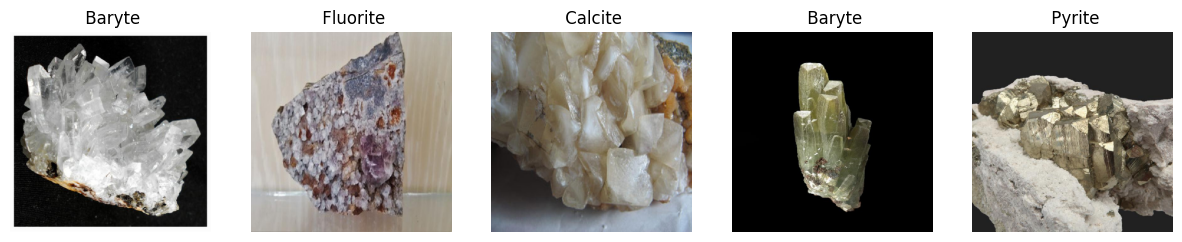

In [8]:
## Plotting random images from the training data
sample_images = train_df.sample(5)  # Select 5 random samples from training data
plt.figure(figsize=(15, 10))                        # Set up a plot size

for i, (_, row) in enumerate(sample_images.iterrows()):
    filename = row['filename']                      # Get the filename of the image
    label = row[1:].astype(int).idxmax()            # Identify the label column where value is 1 (one-hot encoding)
    
    # Construct the path to the image and load it
    image_path = r"D:\Study\Graduation_Project\Data_set\train" + "\\" + filename
    img = load_img(image_path, target_size=(IMAGE_RESIZE, IMAGE_RESIZE))  # Resize image to match model input size
    
    
    plt.subplot(1, 5, i+1)                          # Set up subplot for each image
    plt.imshow(img)                                 # Display the image
    plt.title(label)                                # Set title as the class label
    plt.axis('off')                                 # Hide axis for a cleaner look

plt.show()                                          # Show the figure with all images


## Plotting Random Images from the Validation Data

In this step, we repeat the process of visualizing random samples, but this time, we focus on the validation dataset. The goal is to ensure that the validation images are correctly loaded and resemble the training data in terms of class distribution and quality.

This visualization step helps us in:
- Verifying that the validation data has been properly loaded and preprocessed.
- Ensuring that the images in the validation set are consistent with the images in the training set.
- Giving us a chance to visually inspect random validation images and check if their corresponding labels match expectations.

By displaying five random images from the validation data, we get a quick visual check of the dataset, which can be useful for spotting any potential issues before proceeding with training or evaluation.


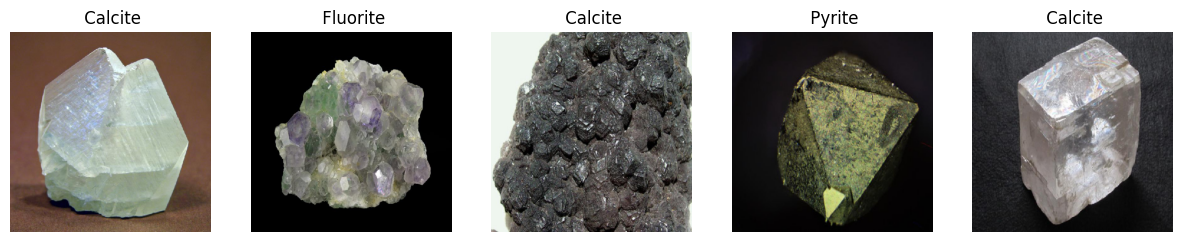

In [9]:
## Plotting random images from the validation data
sample_images = valid_df.sample(5)  # Select 5 random samples from validation data
plt.figure(figsize=(15, 10))                         # Set up a plot size

for i, (_, row) in enumerate(sample_images.iterrows()):
    filename = row['filename']                       # Get the filename of the image
    label = row[1:].astype(int).idxmax()             # Identify the label column where value is 1 (one-hot encoding)
    
    # Construct the path to the image and load it
    image_path = r"D:\Study\Graduation_Project\Data_set\valid" + "\\" + filename
    img = load_img(image_path, target_size=(IMAGE_RESIZE, IMAGE_RESIZE))  # Resize image for model compatibility
    
    plt.subplot(1, 5, i+1)                           # Set up subplot for each image
    plt.imshow(img)                                  # Display the image
    plt.title(label)                                 # Set title as the class label
    plt.axis('off')                                  # Hide axis for a cleaner look

plt.show()                                           # Show the figure with all images


## Plotting Random Images from the Test Data

In this step, we extend the same visualization process to the test dataset. This allows us to inspect five random images from the test data to verify its integrity and confirm that the preprocessing steps have been applied correctly.

By visualizing the test images:
- We can confirm that the images in the test set are being loaded correctly.
- We can verify that the labeling (one-hot encoded) matches the expected class labels.
- It gives us a visual confirmation of how the test data looks and ensures that it has a similar format to the training and validation data.

This helps us ensure consistency across the datasets before proceeding with model evaluation on the test set.


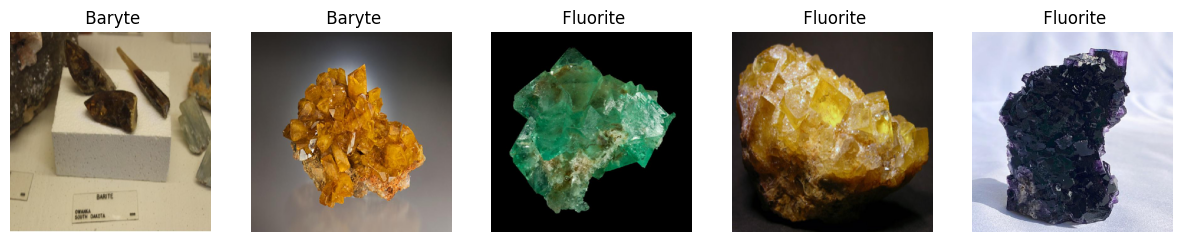

In [11]:
## Plotting random images from the validation data
sample_images = test_df.sample(5)  # Select 5 random samples from validation data
plt.figure(figsize=(15, 10))                         # Set up a plot size

for i, (_, row) in enumerate(sample_images.iterrows()):
    filename = row['filename']                       # Get the filename of the image
    label = row[1:].astype(int).idxmax()             # Identify the label column where value is 1 (one-hot encoding)
    
    # Construct the path to the image and load it
    image_path = r"D:\Study\Graduation_Project\Data_set\test" + "\\" + filename
    img = load_img(image_path, target_size=(IMAGE_RESIZE, IMAGE_RESIZE))  # Resize image for model compatibility
    
    plt.subplot(1, 5, i+1)                           # Set up subplot for each image
    plt.imshow(img)                                  # Display the image
    plt.title(label)                                 # Set title as the class label
    plt.axis('off')                                  # Hide axis for a cleaner look

plt.show()                                           # Show the figure with all images


## Visualizing Class Distribution in the Training Data

In this step, we analyze the distribution of classes in the training data by plotting the count of images for each class. By summing the values across all class columns, we get the total number of images belonging to each class.

- This plot provides insight into how balanced the dataset is in terms of class distribution.
- If the plot shows uneven distribution (i.e., some classes have significantly more images than others), it indicates that the dataset may need balancing techniques such as oversampling, undersampling, or class weighting during model training.
  
This step helps us understand the structure of the dataset and whether any preprocessing or adjustments are required before training the model.


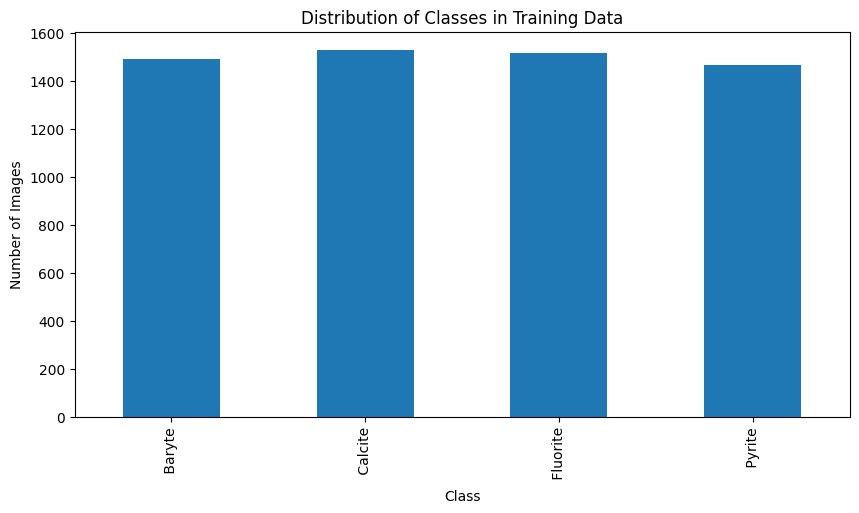

In [12]:
## Counting each class in training images
class_counts = train_df.iloc[:, 1:].sum()           # Sum up all class columns for count of each class

plt.figure(figsize=(10,5))                          # Define figure size
class_counts.plot(kind='bar')                       # Create a bar plot for class distribution
plt.title('Distribution of Classes in Training Data')  # Title of the plot
plt.xlabel('Class')                                 # X-axis label
plt.ylabel('Number of Images')                      # Y-axis label
plt.show()                                          # Show the plot

## Visualizing Class Distribution in the Validation Data

In this step, we analyze the distribution of classes in the validation data by plotting the count of images for each class. Similar to the training data, we sum the values across all class columns to get the total number of images per class.

- This helps us assess whether the validation set is balanced or if certain classes dominate.
- A balanced validation set ensures that the model's performance is evaluated fairly across all classes.

This visualization gives us a quick overview of how the validation set is distributed, allowing us to make informed decisions about further data processing or adjustments if needed.


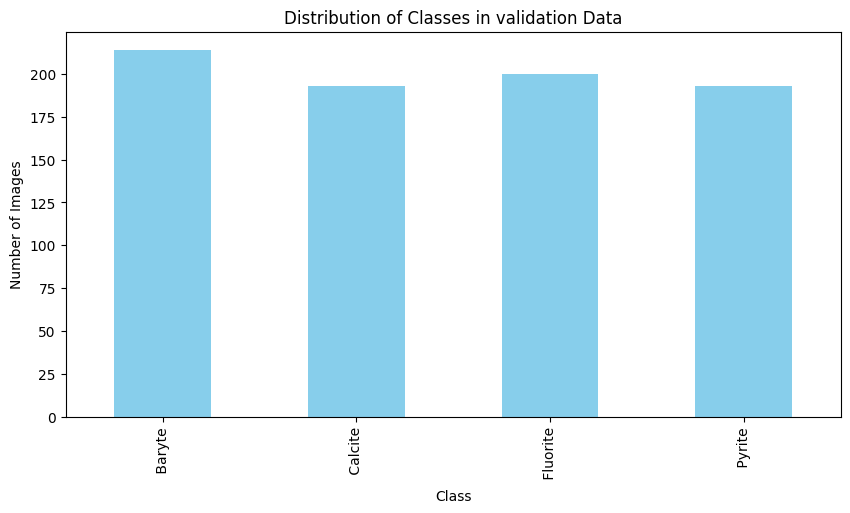

In [14]:
class_counts = valid_df.iloc[:, 1:].sum()


plt.figure(figsize=(10,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes in validation Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


## Visualizing Class Distribution in the Test Data

We plot the class distribution for the test data by summing the image counts for each class, which helps us understand the distribution of images across different categories in the test set.

- This step is crucial to ensure that the test data is also appropriately distributed and balanced.
- Visualizing the class distribution assists in identifying any potential class imbalances that may affect the final model evaluation.

By observing this distribution, we can ensure that the model's performance in the test set is not skewed by the representation of certain classes.


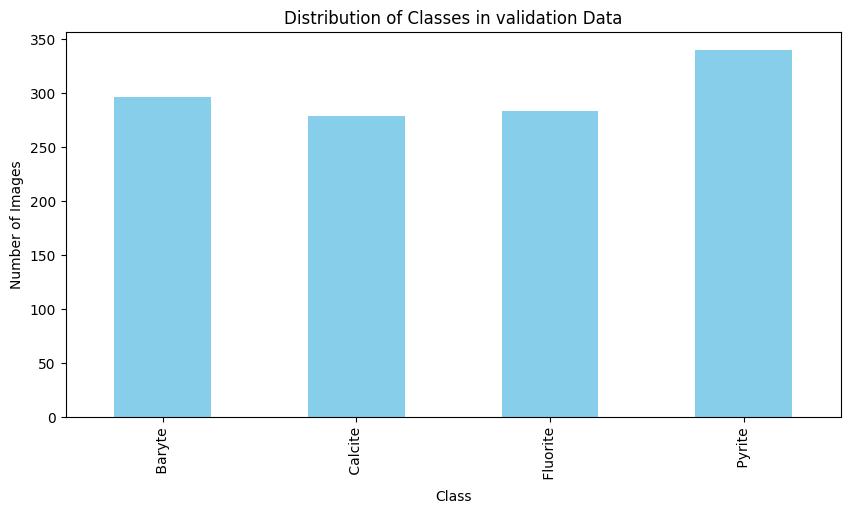

In [15]:
class_counts = test_df.iloc[:, 1:].sum()


plt.figure(figsize=(10,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes in validation Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


## Data Preparation for Model Input

Before feeding the data into the model, we perform the following steps:

1. **Striping column names**: We remove any leading or trailing spaces from the column names in the `train_df`, `valid_df`, and `test_df` datasets to ensure consistency.

2. **Image Data Generators**: 
   - We use the `ImageDataGenerator` class to apply image augmentation for the training data. This includes random transformations like rotation, shifting, zooming, and flipping to make the model more robust and avoid overfitting.
   - For the validation data, we only apply rescaling to standardize the image pixel values.

3. **Data Flow Setup**: 
   - We set up `train_generator` and `valid_generator` to load the image files from the respective directories and map them to their corresponding labels using the `flow_from_dataframe` method.
   - The images are resized to match the input size of the model and normalized using rescaling.
   - The training generator is configured with augmentation, while the validation generator does not shuffle the data to maintain the order for evaluation purposes.

These steps ensure the images are properly processed and ready for training and evaluation by the model.


In [19]:

train_df.columns = train_df.columns.str.strip()
valid_df.columns = valid_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=r"D:\Study\Graduation_Project\Data_set\train",
    x_col="filename",
    y_col=["Baryte", "Calcite", "Fluorite", "Pyrite"],
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=r"D:\Study\Graduation_Project\Data_set\valid",
    x_col="filename",
    y_col=["Baryte", "Calcite", "Fluorite", "Pyrite"],
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

Found 6000 validated image filenames.
Found 800 validated image filenames.


## Model Construction and Transfer Learning

In this step, we build the model using **Transfer Learning** with the pre-trained `InceptionV3` model. Here's how it's done:

1. **Base Model**: 
   - We use the `InceptionV3` model with pre-trained weights from **ImageNet**, but without the top layers (`include_top=False`). This allows us to use the pre-trained convolutional layers while adding our custom fully connected layers on top.
   - The input shape is set to match the resized images (500x500x3).

2. **Freeze Base Model Layers**:
   - We initially freeze all layers in the base model (i.e., make them non-trainable) to prevent their weights from being updated during training. This helps retain the useful features learned from ImageNet.
   - However, we make the last 90 layers trainable to allow fine-tuning, enabling the model to adapt to the specific features of our dataset.

3. **Adding Custom Layers**:
   - After the base model, we add a series of custom layers:
     - **GlobalAveragePooling2D**: This layer reduces the spatial dimensions of the output from the base model, making it suitable for the fully connected layers.
     - **Dense Layers**: We add several fully connected layers with ReLU activation and L2 regularization to prevent overfitting.
     - **BatchNormalization**: This technique normalizes the output of each layer, helping to stabilize and accelerate training.
     - **Dropout Layers**: Dropout is used to prevent overfitting by randomly setting a fraction of input units to 0 during training.
     - **Output Layer**: A softmax activation is applied in the output layer to predict the class probabilities (4 classes in this case).

4. **Model Creation**:
   - We create the final model by specifying the input from the base model and the output from the custom layers.

5. **Model Summary**: 
   - Finally, we print the model summary to check the architecture, including the number of parameters in each layer.

This model is designed to leverage the pre-learned features of `InceptionV3` and adapt it to our specific image classification task.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3))

# Make all layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Make the last 4 layers trainable
for layer in base_model.layers[-90:]:
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
outputs = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=outputs)

# Print summary
model.summary()


## Model Compilation and Callbacks

After constructing the model, we prepare it for training in the following steps:

1. **Model Compilation**:
   - We use the **Adam optimizer** with a learning rate of `LEARNING_RATE` to optimize the model. Adam is a popular choice as it adapts the learning rate based on the gradients.
   - The **loss function** used is **categorical cross-entropy**, which is appropriate for multi-class classification tasks (since we have 4 classes).
   - The model's performance is tracked using the **accuracy** metric during training.

2. **Callbacks**:
   - **EarlyStopping**: This callback monitors the validation loss (`val_loss`) and stops training if the loss does not improve for 15 epochs. Additionally, it restores the best model weights to avoid overfitting.
   - **ReduceLROnPlateau**: This reduces the learning rate by a factor of 0.2 if the validation loss doesn't improve for 3 consecutive epochs. It helps in fine-tuning the model when it's stuck at a plateau.
   - **ModelCheckpoint**: This callback saves the model with the best validation accuracy (`val_accuracy`) during training, ensuring that the model with the highest performance is saved for later use.

These steps set up the model for efficient and robust training, ensuring that it doesn't overfit and that the best performing model is preserved.


In [ ]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_inception_model_7.h5", monitor="val_accuracy", save_best_only=True)


## Model Training

In this step, we train the model using the prepared training and validation data:

1. **Model Fitting**:
   - We call the `fit` method to train the model. The model is trained using the data provided by the `train_generator` (for training) and `valid_generator` (for validation).
   - The training runs for a total of `EPOCHS` epochs, where in each epoch:
     - `steps_per_epoch` specifies the number of batches to process in one epoch, determined by the number of samples in the training data divided by the batch size.
     - `validation_steps` indicates the number of batches from the validation data that will be used to validate the model at the end of each epoch.
   
2. **Callbacks**:
   - We pass the previously defined callbacks (`early_stopping`, `reduce_lr`, `model_checkpoint`) to the `fit` method to monitor and improve the training process, as explained earlier.

By running the training process, the model will adjust its weights based on the data and will also evaluate its performance on the validation data at each epoch to avoid overfitting and improve accuracy.


In [ ]:

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

## Evaluating Model Performance: Accuracy and Loss Plots

In this section, we are visualizing the performance of the trained model over the epochs. We plot the following metrics to understand how well the model is performing:

1. **Accuracy Plot**: 
   - We plot both the training and validation accuracy over the epochs to see how well the model is learning. If the model's accuracy on the validation set starts to stagnate or decrease while the training accuracy increases, it might indicate overfitting.
   
2. **Loss Plot**:
   - Similarly, we plot the loss values for both the training and validation data. A decreasing loss curve generally indicates that the model is learning effectively. If the validation loss begins to increase, it might indicate that the model is overfitting.

These plots help to track the model's learning progress and its ability to generalize to unseen data.


In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluating Model on Validation Data: Classification Report and Confusion Matrix

In this step, we evaluate the model's performance on the validation data using the following:

1. **Classification Report**: 
   - We use `classification_report` from `sklearn` to generate a detailed report that includes the precision, recall, and F1-score for each class. This helps assess how well the model is performing across different classes.
   
2. **Confusion Matrix**:
   - A confusion matrix is calculated using `confusion_matrix`. This matrix shows the counts of correct and incorrect predictions for each class, giving a clear view of where the model is making errors.
   - We then visualize the confusion matrix using `seaborn`'s `heatmap` to get an intuitive view of the performance, with darker colors representing higher values (more correct or incorrect predictions).

These evaluation tools help us understand the model's strengths and weaknesses and how well it generalizes to unseen validation data.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels from the valid_generator (from One-Hot Encoding)
y_true = np.argmax(valid_generator.labels, axis=1)

# Predict probabilities for validation data
y_pred_probs = model.predict(valid_generator, verbose=1)

# Convert probabilities to class predictions
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Print classification report
classes = ["Baryte", "Calcite", "Fluorite", "Pyrite"]
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


## Preparing Test Data for Model Evaluation

In this step, we configure the test data to evaluate the model's performance on previously unseen data. Here are the key actions:

1. **ImageDataGenerator**:
   - We use `ImageDataGenerator` to apply rescaling, where pixel values are normalized by dividing by 255 (i.e., rescaling to a range of 0-1). This is essential because the model was trained with rescaled images.

2. **test_generator**:
   - We use `flow_from_dataframe` to load the images from the `test_df` DataFrame, which contains filenames and corresponding labels. This allows us to generate batches of data directly from the test set.
   - The `x_col` refers to the image filenames, while `y_col` contains the one-hot encoded class labels for "Baryte," "Calcite," "Fluorite," and "Pyrite."
   - `target_size` ensures that each image is resized to the required input shape for the model (matching the image dimensions used during training).
   - `batch_size` controls how many images are loaded into memory at a time, and `class_mode="raw"` ensures that we handle the raw labels without any additional encoding.

This setup prepares the test data to be fed into the trained model for final evaluation.


In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=r"D:\Study\Graduation_Project\Data_set\test",
    x_col="filename",
    y_col=["Baryte", "Calcite", "Fluorite", "Pyrite"],
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
    
)

Found 1200 validated image filenames.


## Evaluating Model on Test Data: Classification Report and Confusion Matrix


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels from the valid_generator (from One-Hot Encoding)
y_true = np.argmax(test_generator.labels, axis=1)

# Predict probabilities for validation data
y_pred_probs = model.predict(test_generator, verbose=1)

# Convert probabilities to class predictions
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Print classification report
classes = ["Baryte", "Calcite", "Fluorite", "Pyrite"]
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
